In [1]:
import sys  
sys.path.insert(0, '..')

In [2]:
from src import detector as de
from src import extractor as ex
from src import accumulator as ac
from src import utils

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import cv2

import numpy as np
from tqdm import tqdm
import os
from collections import defaultdict
import networkx as nx
import seaborn as sns
from sklearn.cluster import DBSCAN
#import hdbscan
import importlib
from src.external.pysnic.algorithms.snic import snic


from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

%matplotlib inline


def crop_center(img,cropx,cropy):
    y,x = img.shape[:-1]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx, :]



In [3]:
# Random pic or fixed
DATASET_FOLDER=f"../Datasets/data/merge_firm_level/"
random_pic = np.random.choice([f for f in os.listdir(DATASET_FOLDER) if (f[-3:]=='png' or f[-3:]=='jpg' or f[-3:]=='bmp' or f[-3:]=='JPG')])
FILENAME = f"{DATASET_FOLDER}{random_pic}"
FILENAME = "../Datasets/data/merge_firm_level/0077_02.png"

#FILENAME = "../Datasets/cvprset/t001.jpg"
#FILENAME = "../Datasets/data/semantic_lvl1/0118_01.png"
#FILENAME = "Datasets/BSDS500/data/images/test/48017.jpg"
#FILENAME=f"Datasets/data/misc/myeloma.jpg"
#FILENAME = "Datasets/data/tmp_final_dset/0104_11.png"
#FILENAME = "../Datasets/data/misc/escher.jpg"
#FILENAME = "../Datasets/cvprset/t000.jpg"

print(FILENAME)


# Read the image and chenge encoding
img = cv2.imread(FILENAME, cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
print(img.shape)

#img = crop_center(img, 832,832)
#img=cv2.imread(FILENAME,cv2.IMREAD_COLOR)
#cv2.imwrite("/tmp/test.tif",img)
#img=cv2.imread("/tmp/test.tif")


# If the image is grayscale
#img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

../Datasets/data/merge_firm_level/0077_02.png
(832, 832, 3)


# Compute keypoints

- Localization strategy: Canny
- Descriptor: DAISY 

In [17]:
importlib.reload(ex)
importlib.reload(de)


# Detects interesting points
NSRC_POINTS = 12000
NDST_POINTS = 12000
kpdetector = de.KPDetector()
#src_keypoints, dst_keypoints = kpdetector.kp_by_entropy(img, NSRC_POINTS,NDST_POINTS)
#src_keypoints, dst_keypoints = kpdetector.kp_by_grid(img, srcstep=15, dststep=15)

#src_keypoints, dst_keypoints = kpdetector.kp_by_fft(img, NSRC_POINTS,NDST_POINTS, viz=True)
src_keypoints, dst_keypoints = kpdetector.kp_by_canny(img, NSRC_POINTS,NDST_POINTS)

# Extracts the descriptors from previous detected points
extractor = ex.Extractor()
kp1, des1, kp2, des2 = extractor.extract_daisy(src_keypoints, dst_keypoints, img)#  cv2.blur(img,(5,5)))

# ROOTSIFT

#kp1, des1, kp2, des2 = extractor.extract_sift(src_keypoints, dst_keypoints, img)
#des1 /= (des1.sum(axis=1, keepdims=True) + 1e-7)
#des1 = np.sqrt(des1)
#des2 /= (des2.sum(axis=1, keepdims=True) + 1e-7)
#des2 = np.sqrt(des2)


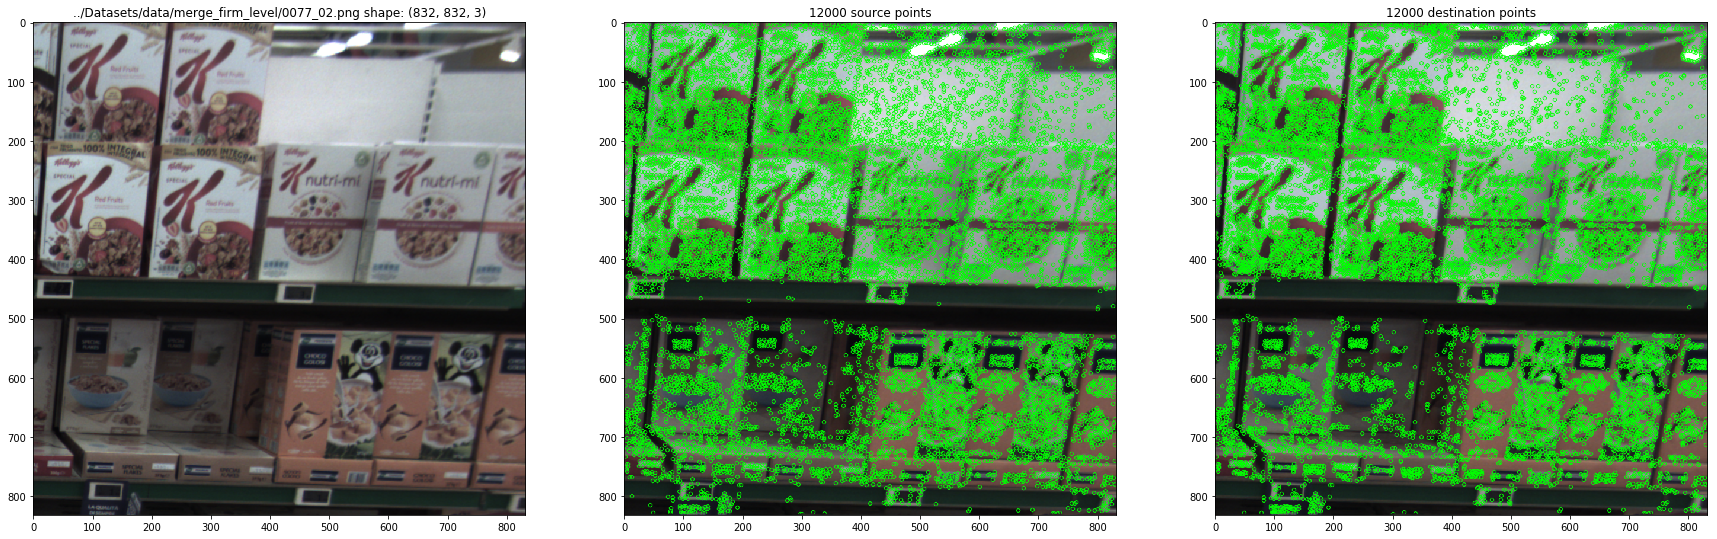

In [18]:

# Visualization
fig = plt.figure(figsize=(30,15))

plt.subplot(1,3,1)
plt.title(f"{FILENAME} shape: {img.shape}")
plt.imshow(img)

plt.subplot(1,3,2)
plt.title(f"{NSRC_POINTS} source points")
plt.imshow(cv2.drawKeypoints(img, src_keypoints, img.copy(),(0,255,0)))
plt.subplot(1,3,3)
plt.title(f"{NDST_POINTS} destination points")
plt.imshow(cv2.drawKeypoints(img, dst_keypoints, img.copy(),(0,255,0)))
plt.show()

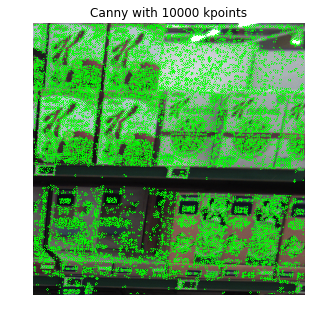

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
plt.axis('off')
plt.imshow(cv2.drawKeypoints(img, src_keypoints, img.copy(),(0,255,0)))
plt.title("Canny with 10000 kpoints")
fig.savefig(f"./example.png", dpi=300)
plt.show()



# Splash computation in Accumulator plane

- For each src descriptor compute top `K` approximate dst neighbors
- Add splash ends in Accumulator 
    - Gaussian voting scheme ksize=11. Kernel sums to 1.
    - Exponential decreasing weight of the gaussian. `kernel * 1/rank**2`
    - Do NOT include splash ends within `RADIUS`
    


In [8]:
importlib.reload(ac)

# Declaration of the Accumulator
accum_cls = ac.Accumulator(img)

# PARAMETERS
#K =  7
#RADIUS = 100
K =  5
RADIUS = 150


# https://github.com/mariusmuja/flann/issues/143
FLANN_INDEX_KDTREE = 0
flann = cv2.FlannBasedMatcher(dict(algorithm = FLANN_INDEX_KDTREE, trees = 5), dict(checks=50))
matches = flann.knnMatch(des1,des2,k=K)

#roi = {"start":(675,1500), "end":(675+118,1500+206)}

# Match comparisons
imgc = img.copy()

for i, m_list in tqdm(enumerate(matches)):

    o = (int(kp1[i].pt[1]), int(kp1[i].pt[0]))
    #if not utils.inRoi(o, roi):
    #    continue
    #cv2.line(imgc, o[::-1], d[::-1], (0,255,0), 1)
    #cv2.circle(imgc, o[::-1], 5, (255,0,0), -1)
    
    points = []
    rank = 1
    for m in m_list:
        
        d = (int(kp2[m.trainIdx].pt[1]), int(kp2[m.trainIdx].pt[0]))

        # Removes the points near the source
        if utils.eu_dist(o, d) > RADIUS:

            points.append(d)
            accum_cls.add_vote(o, d, rank**2, ksize=11)
            rank += 1
            
    accum_cls.add_splash(o, points)


2855it [00:00, 4962.99it/s]


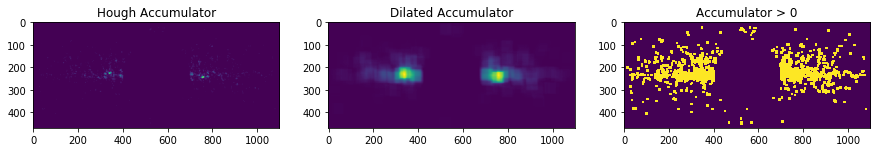

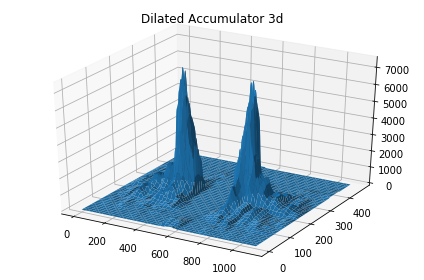

In [9]:

# Accumulator visualization
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

axs[0].set_title("Hough Accumulator")
axs[0].imshow(accum_cls.accumulator)

axs[1].set_title("Dilated Accumulator")
axs[1].imshow(cv2.filter2D(accum_cls.accumulator,-1, np.ones((51,51),np.uint8)))

axs[2].set_title("Accumulator > 0")
axs[2].imshow(accum_cls.accumulator>0)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
y = np.arange(0, accum_cls.accumulator.shape[0])
x = np.arange(0, accum_cls.accumulator.shape[1])
x, y = np.meshgrid(x, y)
ax.set_title("Dilated Accumulator 3d")
ax.plot_surface(x,y, cv2.filter2D(accum_cls.accumulator,-1, np.ones((51,51),np.uint8)))
plt.tight_layout()
plt.show()

# Accumulator plane Thresholding

Just threshold above 1.


In [10]:
THRESHOLD = 5
x, y = np.where(accum_cls.accumulator > THRESHOLD)

vote_list = accum_cls.votes.copy()
idx1 = np.nonzero(np.isin(vote_list[:,0], x))[0]
idx2 = np.nonzero(np.isin(vote_list[idx1,1], y))[0]
idx3 = idx1[idx2]
mask = np.zeros(vote_list.shape[0])

coords = np.concatenate((x.reshape(-1,1), y.reshape(-1,1)), axis=1)

for coord in coords:
    idx4 = np.where(np.all(vote_list[idx3,0:2] == coord, axis=1))[0]
    mask[idx3[idx4]] = 1

vote_list = vote_list[np.nonzero(mask)[0]]

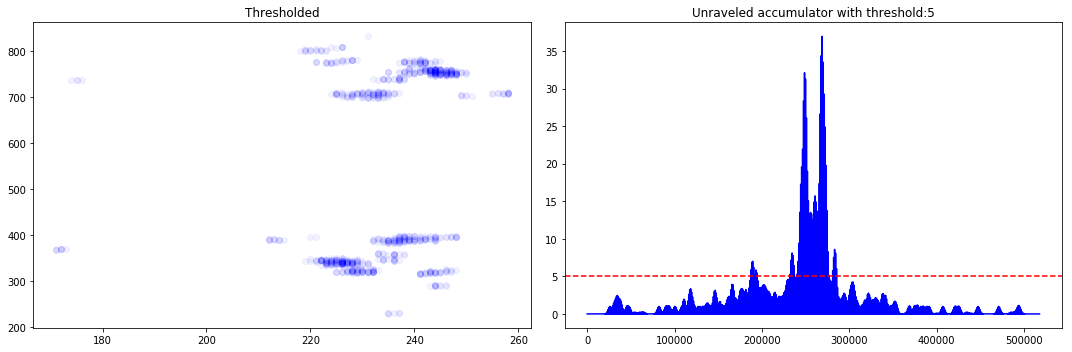

In [11]:
# Debug plot
fig = plt.figure(figsize=(15,5))
#plt.subplot(1,3,1)
#plt.title(f"Thresholded accumulator {THRESHOLD}")
#plt.scatter(x,y,alpha=0.05, c='b')

plt.subplot(1,2,1)
plt.title(f"Thresholded")
plt.scatter(vote_list[:,0], vote_list[:,1], c='b', alpha=0.05)

plt.subplot(1,2,2)
plt.title(f"Unraveled accumulator with threshold:{THRESHOLD}")
plt.plot(accum_cls.accumulator.flatten(), c='b')
plt.axhline(y=THRESHOLD, color='r', linestyle='dashed')
plt.tight_layout()

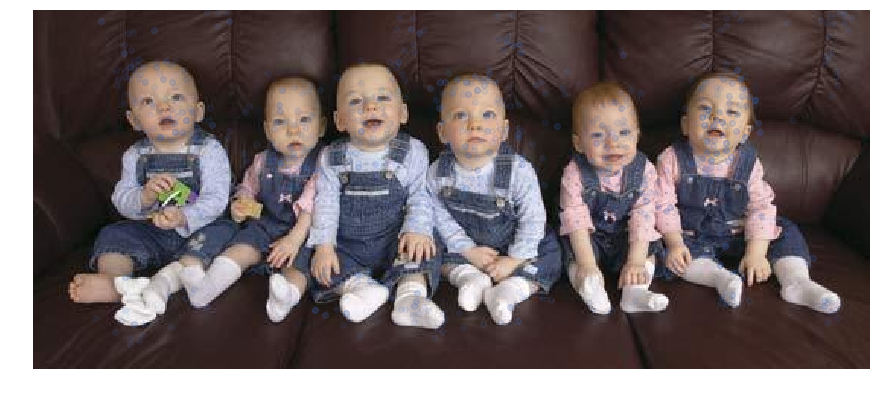

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15))
plt.axis('off')
ax.imshow(img)
ax.scatter(vote_list[:,3], vote_list[:,2], c='#426ab9ff', alpha=0.1)
fig.savefig(f"../best_figures/hotspots.png", dpi=300)
plt.show()

# Superpixels

In [23]:
N_SEGMENTS = 50

segments = slic(img, n_segments = N_SEGMENTS,compactness=30, sigma = 1)


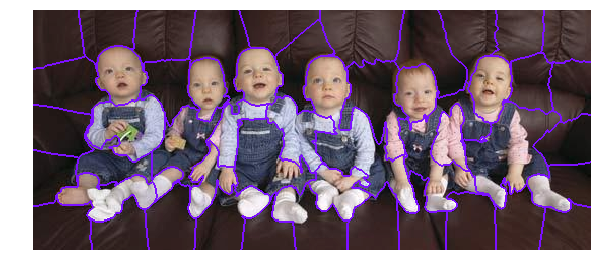

48


In [24]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax.imshow(mark_boundaries(img, segments,color=(124/255, 16/255, 255/255), mode="thick"))
plt.axis("off")
plt.savefig("../best_figures/segmentation.png", dpi=300)
plt.show()
print(segments.max())

# Graph creation

- $G=(V,E)$ 
    - $|V|=$ number of clusters found
    - $E =$ Put 1 vote between $v_{1}$ and $v_{2}$ if there is an agreement between two clusters i.e. (two splashes: src→dst AND dst→src)


In [25]:
connections = []
for vote in vote_list:
    pi1 = vote[2:4]
    pi2 = vote[4:6]
    connections.append((segments[pi1[0],pi1[1]],segments[pi2[0],pi2[1]]))

In [26]:
n_clusters = segments.max()+1

In [27]:
adj_mat = np.zeros((n_clusters, n_clusters))
for c in connections:
    adj_mat[c[0], c[1]] += 1
    adj_mat[c[1], c[0]] += 1

np.fill_diagonal(adj_mat, 0)


#adj_mat *= np.sqrt(adj_mat)

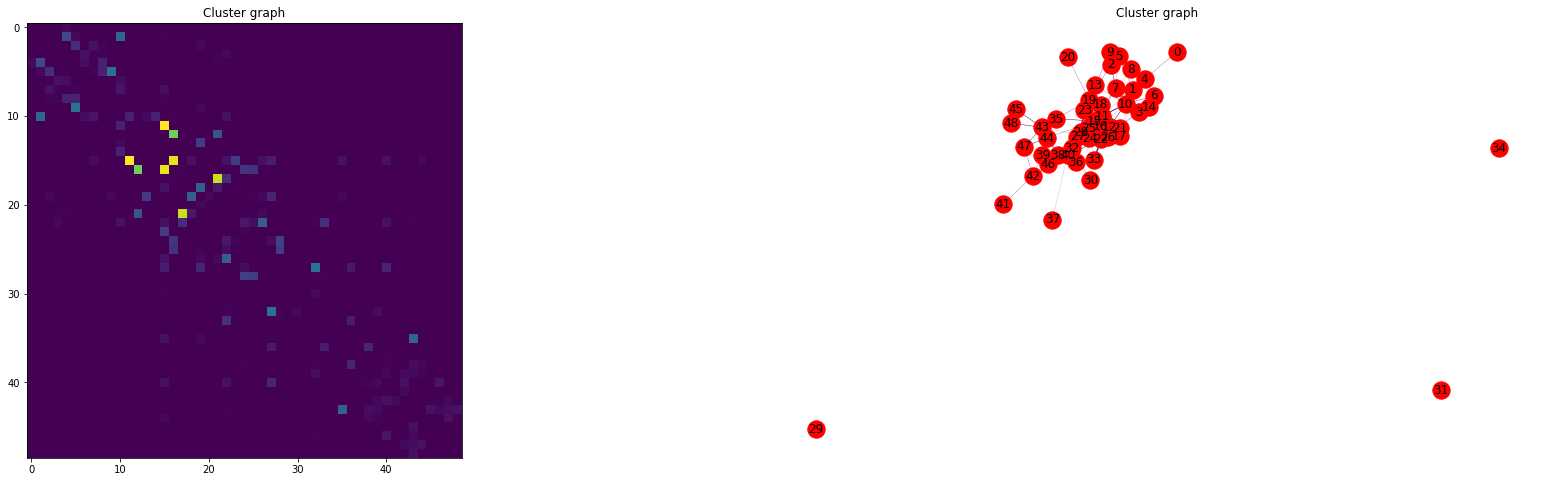

In [28]:
 
fig = plt.figure(figsize=(30,8))
plt.subplot(1,2,1)
plt.title(f"Cluster graph")
plt.imshow(adj_mat)


# Draw graph
G = nx.from_numpy_array(adj_mat)
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
weights = np.array(weights)
weights /= weights.max()
maxw = weights.max()
weights *= 10
plt.subplot(1,2,2)
plt.title(f"Cluster graph")

#G.remove_nodes_from(list(nx.isolates(G)))

#pos = nx.random_layout(G)
nx.draw(G, node_color='r', with_labels=True, edge_color=weights, width=weights, cmap=plt.cm.jet)#,  pos = pos)
plt.show()

## Find optimal partition of graph

- Find densely connected components by iterative process: graph corrosion
- At each iteration corrode the graph $G-min(E)$ and compute a score as follows:

$score(P_{i}) = \sum_{cc} \frac{edgesWeight(cc)}{nodes(cc)} - \#cc(P_{i})$ 

Maximize the score to find optimum partition

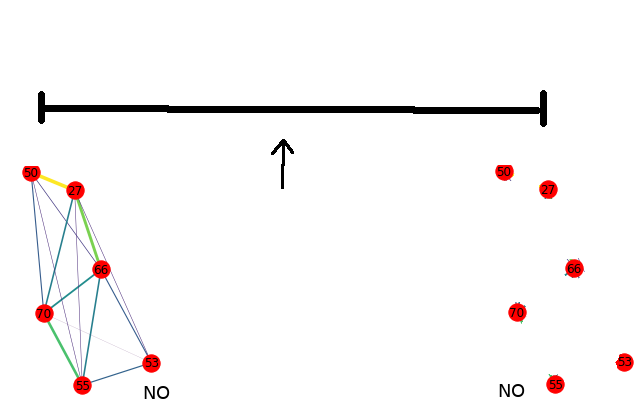

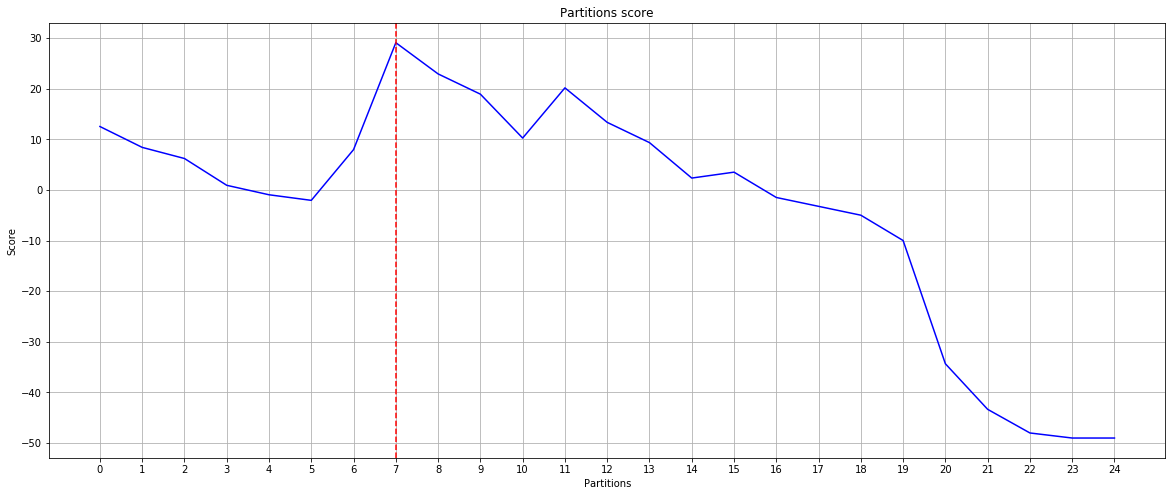

In [29]:
importlib.reload(utils)
best_partition_nodes, best_partition = utils.findBestPartition_alt(adj_mat,min_cl=2, viz=True)
#utils.draw_subgraphs(adj_mat, final_partition_nodes, maxw)
#utils.plot_segmentation(img, best_partition_nodes, clustering, vote_list)

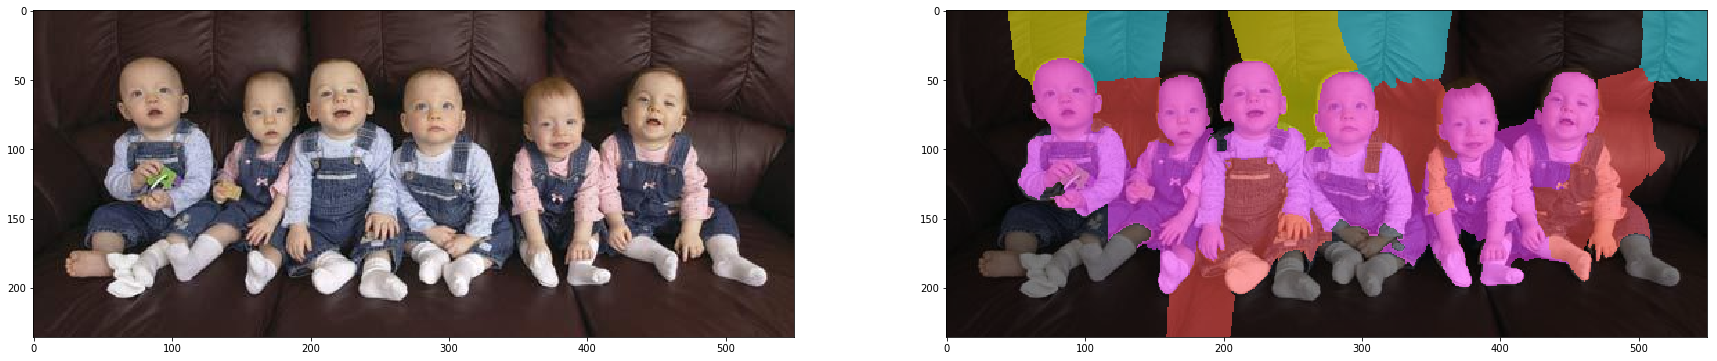

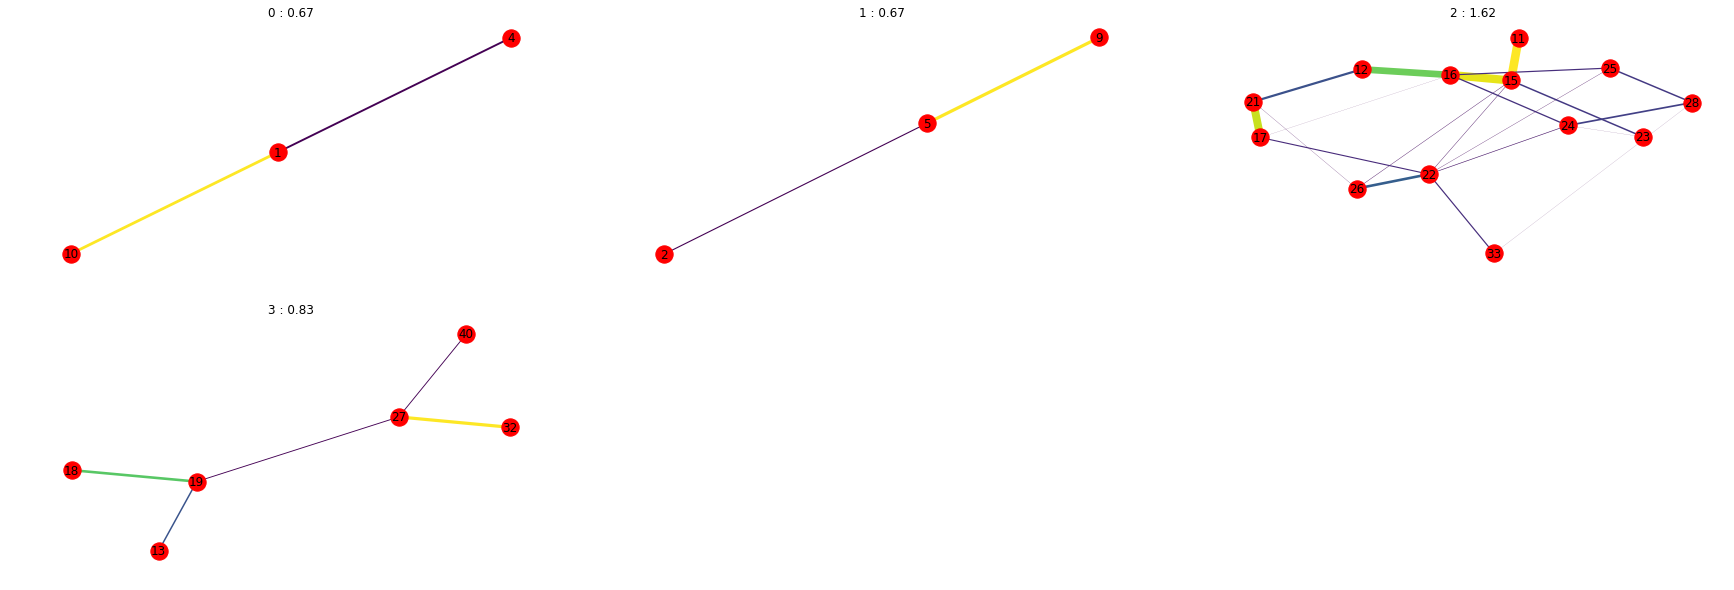

In [30]:
importlib.reload(utils)
pred,rmask = utils.plot_spixel_segmentation(img, best_partition_nodes, segments)#, path=f"./res/superpixel/{N_SEGMENTS:05}.png")    
utils.draw_subgraphs(adj_mat, best_partition_nodes, maxw)

(-0.5, 549.5, 235.5, -0.5)

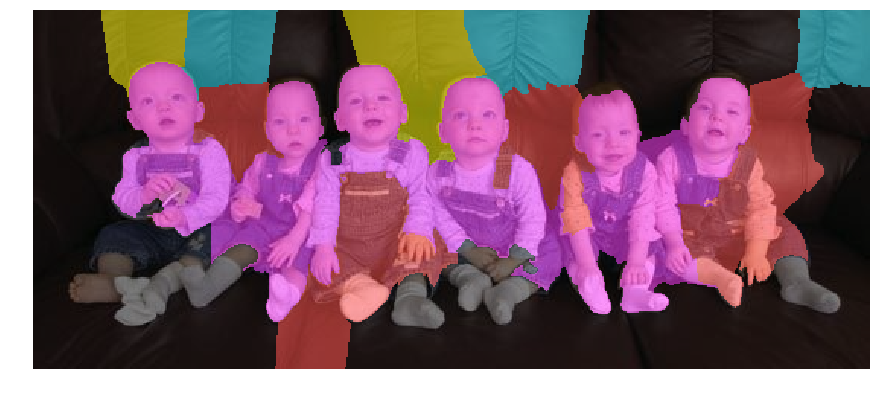

In [31]:
fig = plt.figure(figsize=(15,15))

#kernel = np.ones((5,5),np.float32)/25
#rmask = cv2.filter2D(rmask,-1,kernel)

plt.imshow(img)
plt.imshow(rmask, alpha=0.5)
plt.axis('off')


# Measures

Install  `pipenv` then `pipenv install labelme`

```bash
pipenv run python labelme2voc.py Datasets/data/832_firm_segmentation Datasets/data/832_firm_segmentation_annotated --labels Datasets/data/832_firm_segmentation/labels.txt
```

This is our annotation

In [ ]:
pred = pred.astype(np.int)
print(np.unique(pred))
plt.figure(figsize=(5,5))
plt.imshow(pred)
plt.show()

In [ ]:
GT_FOLDER = "../Datasets/101_ObjectCategories/Faces_collage_gt/"
gtid = FILENAME[-9:].split(".")[0]
gt = np.load(GT_FOLDER + f"{gtid}.npy")

for p in np.unique(pred):
    tmp = (pred==p)
        
    tmp2 = gt>0
    
    intersection = (tmp*tmp2)>0
    
    index = np.count_nonzero(intersection) / np.count_nonzero(tmp)
    
    precision = (np.unique(intersection*gt).size -1) / (np.unique(gt).size -1) # precision == recall
    print(f"i:{index} p:{precision}")
    
    res = intersection*gt
    
    print(np.unique(res))
    
    plt.figure(figsize=(25,15))
    plt.imshow(res==1)
    plt.show()

In [ ]:
plt.figure(figsize=(25,15))
plt.imshow(gt==1)

In [72]:
fallback_max_precision = -1
max_precision = -1
for p in np.unique(pred):
    if p == 0:
        continue
    tmp1 = (pred==p)
    tmp2 = gt>0
    intersection = (tmp1*tmp2)>0

    index = np.count_nonzero(intersection) / np.count_nonzero(tmp1)
    precision = (np.unique(intersection*gt).size -1) / (np.unique(gt).size -1) # precision == recall

    if (index >= 0.7) and (precision > max_precision):
        max_precision = precision

    if precision > fallback_max_precision:
        fallback_max_precision = precision
print(precision)
print((np.unique(gt).size -1))
print((np.unique(intersection*gt).size -1))
print(5/6)

1.0
1
1
0.8333333333333334


# Annotated Semantical Classes

In [28]:
firms_cls = DATASET_FOLDER+"annotation/SegmentationClass/"
gt_file = firms_cls+f'{FILENAME[-11:][:-4]}.npy'
gt = np.load(gt_file)
plt.figure(figsize=(5,5))
plt.imshow(gt)
print(np.unique(gt))

FileNotFoundError: [Errno 2] No such file or directory: '../Datasets/101_ObjectCategories/Faces_collage/annotation/SegmentationClass/e/00106.npy'

# Annotated Single Objects

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


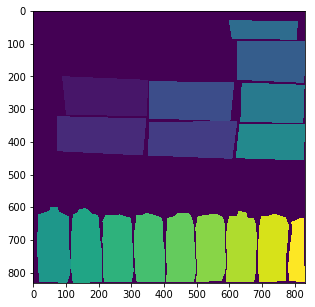

In [22]:
obj_cls = DATASET_FOLDER+"annotation/SegmentationObject/"

gt_file = obj_cls+f'{FILENAME[-11:][:-4]}.npy'
gt_obj = np.load(gt_file)
plt.figure(figsize=(5,5))
plt.imshow(gt_obj)
print(np.unique(gt_obj))

# Jaccard Index - IOU

In [23]:
from sklearn.metrics import jaccard_score

jaccard_score((gt>0).astype(np.int).flatten(), (pred>0).astype(np.int).flatten())

0.6871220261733086

# Total pattern detected (object coverage)


pattern found $\cap$ gt  


In [24]:
binary_pred = (pred>0).astype(np.int)
binary_gt = (gt>0).astype(np.int)

In [25]:
((binary_pred + binary_gt )>1).sum()/(binary_gt ).sum()

0.7432457851958953

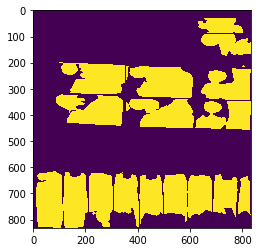

In [26]:
plt.imshow((binary_pred + binary_gt )>1)

# Check semantical consinstency of detection




$$\frac{1}{\left | \mathbf{C}\right |}\sum_{c \in \mathbf{C}}    \frac{mode(c)}{\left | c \right |}$$

------

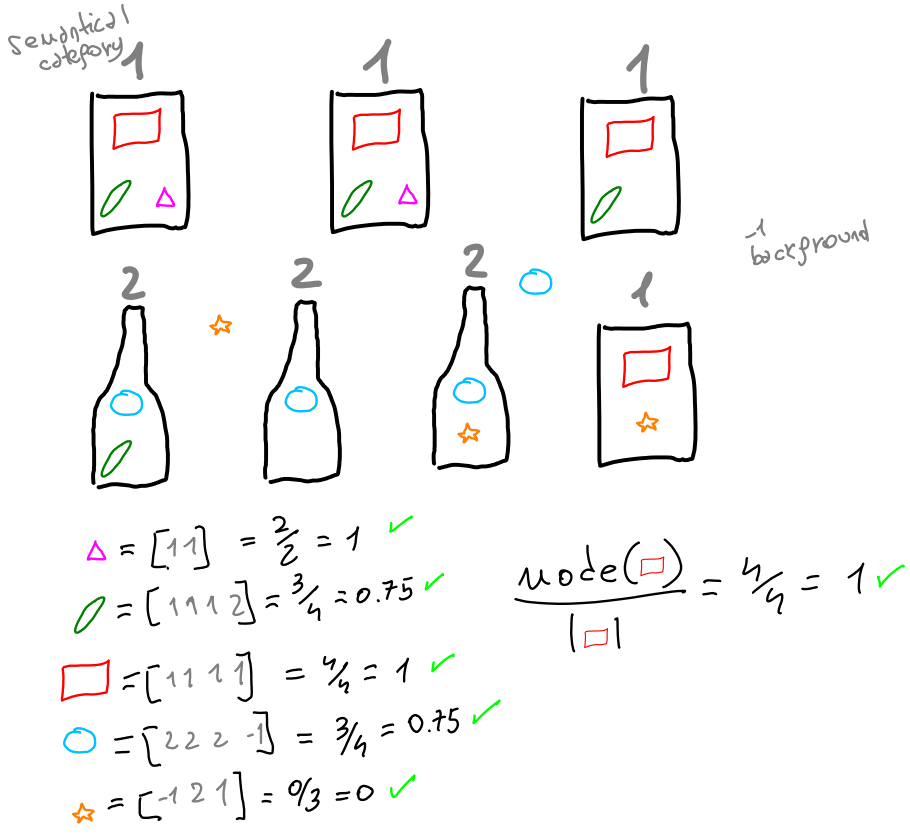

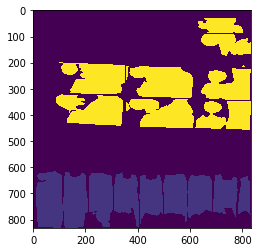

In [27]:
plt.imshow(gt * binary_pred)

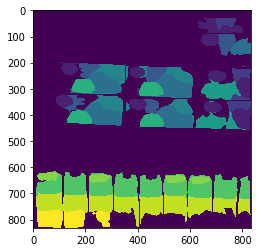

In [28]:
plt.imshow(binary_gt * pred)

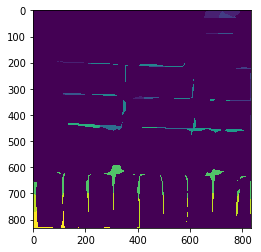

In [29]:
plt.imshow((binary_gt==0) * pred)

# Pattern2Obj + Class2Obj

In [30]:
print(np.unique(pred))
print(np.unique(gt))
print(np.unique(gt_obj))

cs = np.unique(gt)
ps = np.unique(pred)
os = np.unique(gt_obj)

n_cs, n_ps, n_os = cs.size, ps.size, os.size

p2o = np.zeros((n_ps, n_os)).astype(np.int)
c2o = np.zeros((n_cs, n_os)).astype(np.int)

for p, o, c in zip((binary_gt * pred).flatten(), (gt_obj * binary_pred).flatten(), (gt * binary_pred).flatten()):
    x = np.where(ps == p)[0][0]
    k = np.where(os == o)[0][0]
    y = np.where(cs == c)[0][0]

    p2o[x, k] += 1    
    c2o[y, k] += 1


[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0 10 65]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [31]:
p2o.shape, c2o.shape

((12, 18), (3, 18))

### Object2class 

In [32]:
o2c = np.argmax(c2o.T, axis=1)

In [33]:
# Major pattern detected
major_pattern = p2o.sum(axis=1).argsort()[-2]

In [34]:
cindices = np.argwhere(p2o>1)
selfsegmentation = defaultdict(list)
for ids in cindices:
    pattern, object_id = ids[0], ids[1]
    selfsegmentation[pattern].append(o2c[object_id])

In [35]:
selfsegmentation

defaultdict(list,
            {0: [0],
             1: [2, 2, 2, 2, 2, 2, 2, 2],
             2: [2, 2, 2, 2],
             3: [2, 2, 2, 2, 2, 2],
             4: [2, 2, 2, 2, 2],
             5: [2, 2, 2, 2],
             6: [2, 2, 2],
             7: [2, 2, 2, 2],
             8: [1, 1, 1, 1, 1, 1, 1, 1, 1],
             9: [1, 1, 1, 1],
             10: [1, 1, 1, 1, 1, 1, 1, 1, 1],
             11: [1, 1, 1]})

In [36]:
from scipy import stats

consistencies = []

for key in selfsegmentation.keys():
    mode, count = stats.mode(selfsegmentation[key])
    consistencies.append((count / len(selfsegmentation[key]))[0])

print(np.array(consistencies).mean())
print(consistencies)

1.0
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


# recall of detected products

Quanti delle categorie che abbiamo identificate cadono dentro ad un oggetto segmentato


In [37]:
1 - (((p2o.sum(axis=0) == 0).sum())/(p2o.shape[1]-1))

1.0

 # recall for each class

In [38]:
# Quanti oggetti ci sono di classe semantica x?

obj2cls = np.zeros((n_os,n_cs)).astype(np.int)

for o, c  in zip(gt_obj.flatten(), gt.flatten()):
    x = np.where(os == o)[0][0]
    y = np.where(cs == c)[0][0]
    obj2cls[x,y] += 1


In [39]:
obj_classes = np.where(obj2cls >0)[1]
obj2cls_count = np.unique(obj_classes, return_counts=True)[1]

In [40]:
# In che oggetti cade il pattern p?

np.where(p2o > 0)

(array([ 0,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,
         3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  7,  7,  7,
         7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 11, 11, 11]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  5,  6,  7,  8,  1,  2,  3,  4,
         5,  6,  1,  2,  3,  4,  5,  1,  2,  3,  4,  3,  7,  8,  1,  2,  3,
         4,  9, 10, 11, 12, 13, 14, 15, 16, 17,  9, 11, 14, 15,  9, 10, 11,
        12, 13, 14, 15, 16, 17,  9, 10, 11]))

In [41]:
for classe in np.unique(gt):
    obj_ids = np.unique(gt_obj *(gt == classe))
    print(f"class {classe}\n objs {obj_ids} - {obj_ids.size-1}\n")


class 0
 objs [0] - 0

class 10
 objs [ 0  9 10 11 12 13 14 15 16 17] - 9

class 65
 objs [0 1 2 3 4 5 6 7 8] - 8



In [42]:
for pattern in np.unique(pred):
    obj_ids = np.unique(gt_obj *(pred == pattern))
    print(f"pattern {pattern}\n objs {obj_ids}\n cls {cs[obj_classes[obj_ids]]}\n")


pattern 0
 objs [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
 cls [ 0 65 65 65 65 65 65 65 65 10 10 10 10 10 10 10 10 10]

pattern 1
 objs [0 1 2 3 4 5 6 7 8]
 cls [ 0 65 65 65 65 65 65 65 65]

pattern 2
 objs [0 5 6 7 8]
 cls [ 0 65 65 65 65]

pattern 3
 objs [0 1 2 3 4 5 6]
 cls [ 0 65 65 65 65 65 65]

pattern 4
 objs [0 1 2 3 4 5]
 cls [ 0 65 65 65 65 65]

pattern 5
 objs [0 1 2 3 4]
 cls [ 0 65 65 65 65]

pattern 6
 objs [0 3 7 8]
 cls [ 0 65 65 65]

pattern 7
 objs [0 1 2 3 4]
 cls [ 0 65 65 65 65]

pattern 8
 objs [ 0  9 10 11 12 13 14 15 16 17]
 cls [ 0 10 10 10 10 10 10 10 10 10]

pattern 9
 objs [ 0  9 11 14 15]
 cls [ 0 10 10 10 10]

pattern 10
 objs [ 0  9 10 11 12 13 14 15 16 17]
 cls [ 0 10 10 10 10 10 10 10 10 10]

pattern 11
 objs [ 0  9 10 11]
 cls [ 0 10 10 10]



In [43]:
for pattern in np.unique(pred):
    cls_ids = np.unique(gt *(pred == pattern))
    print(f"pattern {pattern} - class {cls_ids}")

pattern 0 - class [ 0 10 65]
pattern 1 - class [ 0 65]
pattern 2 - class [ 0 65]
pattern 3 - class [ 0 65]
pattern 4 - class [ 0 65]
pattern 5 - class [ 0 65]
pattern 6 - class [ 0 65]
pattern 7 - class [ 0 65]
pattern 8 - class [ 0 10]
pattern 9 - class [ 0 10]
pattern 10 - class [ 0 10]
pattern 11 - class [ 0 10]


In [44]:
mean_recalls = []
for classe in np.unique(gt):
    obj_ids = np.unique(gt_obj *(gt == classe))
    cls_cardinality = obj_ids.size-1
    if classe == 0:
        continue
    print(f"classe {classe}\n") 
    
    maxrecall = -1
    for pattern in np.unique(pred):
        if pattern == 0:
            continue
        pred_obj_ids = np.unique(gt_obj *(pred == pattern))
        
        n_cls = np.where(cs[obj_classes[pred_obj_ids]] == classe)[0].size
        
        print(cs[obj_classes[pred_obj_ids]])
        
        
        recall = n_cls/cls_cardinality
        print(f"pattern {pattern} : {n_cls}/{cls_cardinality} =  {recall}")
        if maxrecall < recall:
            maxrecall = recall
    mean_recalls.append(maxrecall)
    
print(np.array(mean_recalls).mean())


classe 10

[ 0 65 65 65 65 65 65 65 65]
pattern 1 : 0/9 =  0.0
[ 0 65 65 65 65]
pattern 2 : 0/9 =  0.0
[ 0 65 65 65 65 65 65]
pattern 3 : 0/9 =  0.0
[ 0 65 65 65 65 65]
pattern 4 : 0/9 =  0.0
[ 0 65 65 65 65]
pattern 5 : 0/9 =  0.0
[ 0 65 65 65]
pattern 6 : 0/9 =  0.0
[ 0 65 65 65 65]
pattern 7 : 0/9 =  0.0
[ 0 10 10 10 10 10 10 10 10 10]
pattern 8 : 9/9 =  1.0
[ 0 10 10 10 10]
pattern 9 : 4/9 =  0.4444444444444444
[ 0 10 10 10 10 10 10 10 10 10]
pattern 10 : 9/9 =  1.0
[ 0 10 10 10]
pattern 11 : 3/9 =  0.3333333333333333
classe 65

[ 0 65 65 65 65 65 65 65 65]
pattern 1 : 8/8 =  1.0
[ 0 65 65 65 65]
pattern 2 : 4/8 =  0.5
[ 0 65 65 65 65 65 65]
pattern 3 : 6/8 =  0.75
[ 0 65 65 65 65 65]
pattern 4 : 5/8 =  0.625
[ 0 65 65 65 65]
pattern 5 : 4/8 =  0.5
[ 0 65 65 65]
pattern 6 : 3/8 =  0.375
[ 0 65 65 65 65]
pattern 7 : 4/8 =  0.5
[ 0 10 10 10 10 10 10 10 10 10]
pattern 8 : 0/8 =  0.0
[ 0 10 10 10 10]
pattern 9 : 0/8 =  0.0
[ 0 10 10 10 10 10 10 10 10 10]
pattern 10 : 0/8 =  0.0
[ 0 10 

# Baseline

SLIC + KMeans

In [21]:
classes = np.unique(segments)
maxl = -1
minl = np.inf
for i in classes:
    
    l = img[np.where(segments == i)].flatten().size
    if  maxl < l:
        maxl = l
    if l < minl:
        minl = l
print(maxl)
print(minl)



53853
14439


In [22]:
A = img[np.where(segments == 0)].flatten()
B = np.pad(A, (0, maxl - A.size), 'constant')

In [23]:
print(B.shape)

(53853,)


In [24]:
segmentation = np.zeros((classes.size,maxl))
for i in classes:
    A = img[np.where(segments == i)].flatten()
    B = np.pad(A, (0, maxl - A.size), 'constant')
    segmentation[i] = B
segmentation

array([[ 14.,  15.,  10., ...,   0.,   0.,   0.],
       [ 57.,  39.,  19., ...,   0.,   0.,   0.],
       [ 25.,  21.,  10., ...,   0.,   0.,   0.],
       ...,
       [ 67.,  84., 104., ...,   0.,   0.,   0.],
       [ 32.,  24.,  13., ...,   0.,   0.,   0.],
       [165., 161., 176., ...,   0.,   0.,   0.]])

In [25]:
from sklearn.cluster import KMeans

In [26]:
kmeans = KMeans(n_clusters=len(np.unique(gt)), random_state=0).fit(segmentation)

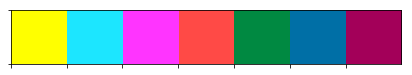

In [41]:
sns.set_palette(utils.FLATUI[:len(np.unique(gt))])
color_palette = sns.color_palette()
sns.palplot(color_palette)
mask = np.zeros(img.shape)
base_pred = np.zeros(img.shape[:-1])
for i in classes:
    #if kmeans.labels_[i]==0:
        #pass
        #continue
    mask[np.where(segments == i)] = color_palette[kmeans.labels_[i]]
    base_pred[np.where(segments == i)] = kmeans.labels_[i]

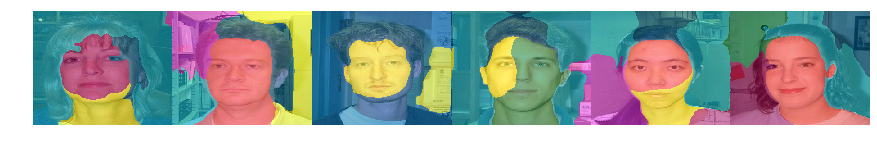

In [37]:
fig = plt.figure(figsize=(15,15))
plt.imshow(img)
#kernel = np.ones((5,5),np.float32)/25
#rmask = cv2.filter2D(mask,-1,kernel)
plt.imshow(mask, alpha=0.5)
plt.axis('off')
fig.savefig("./baseline_selfsegmentation.png")

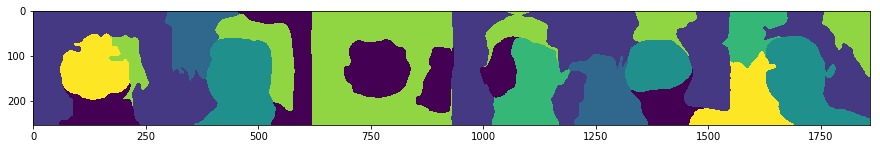

In [38]:
plt.figure(figsize=(15,15))
plt.imshow(base_pred)

In [42]:
1/6

0.16666666666666666

10.0